In [0]:
! pip install libtlda

In [0]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.datasets import make_low_rank_matrix
from sklearn.linear_model import MultiTaskLasso, Lasso, Ridge, LinearRegression

from libtlda.iw import ImportanceWeightedClassifier

# TP 5

# Régression de faible rang sur des données simulées

* Créer une matrice de rang faible $W$. Afficher la matrice avec la commande `imshow`.

* Générer des données d'apprentissage $\{(x_i,y_i), i=1,\ldots,n\}$ suivant le modèle $y_i = Wx_i + \epsilon_i$.

In [0]:
def generate_low_rank_data(n_samples, n_features, rank):
    # generate n_features-D data
    X = np.random.random((n_samples, n_features))

    # generate a low rank matrix as weights for our data model
    W = make_low_rank_matrix(n_features, n_samples, rank)

    # other way to generate low ranked matrix
    # ---
    # W = np.random.random((n_features, rank))
    # W = W @ W.T

    # construct targets with X and Y
    Y = W @ X

    # add some noise to our data
    variance = 0.05
    # Y += np.random.normal(0, variance, (n_samples, n_features))

    return X, Y, W

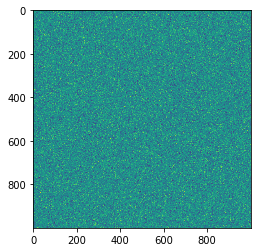

In [4]:
n_samples, n_features, rank = 1000, 1000, 37
x, y, w = generate_low_rank_data(n_samples, n_features, rank)

# plot the low ranked matrix
plt.imshow(w)
plt.show()

* Implémenter la méthode de régression de faible rang.


In [0]:
def ols_regression(data, target):
    return np.linalg.inv(data.T @ data) @ data.T @ target

def low_ranked_regression(data, target, rank):
    # ordinary least square regression
    weights = ols_regression(data, target)

    # svd decomposition
    _, _, v = np.linalg.svd(data @ weights)

    # we will keep only the `rank` best singular values
    best_v = v[:rank].T @ v[:rank]

    return weights @ best_v

* Evaluer les performances de prédiction de la régression de faible rang sur un jeu de données test. Comparer les résultats avec la régression par moindre carrés.

* Afficher les matrices de paramètres $W_r$ et $W_{LS}$ obtenues par les deux méthodes et comparer les résultats. 

* Evaluer l'impact du choix du rang sur les résultats. 


In [0]:
distances_lr, distances_ols = [], []
results_lr, results_ols = [], []

# ordinary least square regression
weights_ols = ols_regression(x, y)
distance_ols =  np.linalg.norm(w - weights_ols) # y - (x @ weights_ols)

# try various ranks
search_ranks = range(1, 30)

for search_rank in search_ranks:
    # low ranked regression
    weights_lr = low_ranked_regression(x, y, search_rank)
    distances_lr.append(np.linalg.norm(w - weights_lr)) # y - (x @ weights_lr)))
    results_lr.append(weights_lr)

    # ols regression
    distances_ols.append(distance_ols)
    results_ols.append(weights_ols)

In [7]:
# let's plot distances !
fig = go.Figure(
    data=[
        go.Scatter(
            y=distances_ols,
            mode='lines',
            name='Ordinary Least Square regression'
        ),
        go.Scatter(
            y=distances_lr,
            mode='lines',
            name='Low Rank regression'
        ),
    ]
)
fig.show()

In [8]:
"""
print('Ordinary Least Square')
plt.imshow(results_ols[0])
plt.show()

print('Low Rank')
plt.imshow(results_lr[0])
plt.show()

print('Original weights')
plt.imshow(w)
plt.show()
"""

"\nprint('Ordinary Least Square')\nplt.imshow(results_ols[0])\nplt.show()\n\nprint('Low Rank')\nplt.imshow(results_lr[0])\nplt.show()\n\nprint('Original weights')\nplt.imshow(w)\nplt.show()\n"

## **Conclusions régression de faible rang sur des données simulées**

* La régression de faible rang fonctionne mieux que la régression par moindres carrés.

* Plus le nombre de valeurs singulières considérées dans la régression de faible rang augmente, plus la régression LR se rapproche de celle OLS et donc perd en performance.

# Apprentissage multi-tâche et régularisation



*   Télécharger un jeu de données d'apprentissage multi-tâche. (Vous pouvez utiliser un jeu de données de régression multivariée)

*   La régression multitaskLasso est déjà  implémenté dans le module `linear_model` de scikit-learn. Expliquer le fonctionnement de cette méthode.


*   Comparer les méthodes de régression ridge, régression Lasso, régression à rang faible et régression multitaskLasso.



In [0]:
# Generate some 2D coefficients with sine waves with random frequency and phase
n_samples, n_features, n_tasks = 100, 30, 40
n_relevant_features = 5
coef = np.zeros((n_tasks, n_features))
times = np.linspace(0, 2 * np.pi, n_tasks)
for k in range(n_relevant_features):
    coef[:, k] = np.sin((1. + np.random.randn(1, 1)) * times + 3 * np.random.randn(1, 1))

X = np.random.randn(n_samples, n_features)
Y = np.dot(X, coef.T) + np.random.randn(n_samples, n_tasks)

# [print(y) for y in Y.T]

coef_ridge_ = np.array([Ridge(alpha=0.5).fit(X, y).coef_ for y in Y.T])
coef_lasso_ = np.array([Lasso(alpha=0.5).fit(X, y).coef_ for y in Y.T])
coef_multi_task_lasso_ = MultiTaskLasso(alpha=1.).fit(X, Y).coef_

coef_low_ranked_ = low_ranked_regression(X, Y, 3)

* Afficher les features sélectionnés par la régression Lasso et MultiTaskLasso

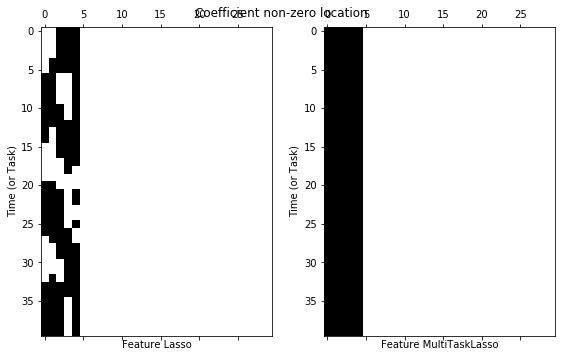

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot support and time series
fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.spy(coef_lasso_)
plt.xlabel('Feature Lasso')
plt.ylabel('Time (or Task)')

plt.subplot(1, 2, 2)
plt.spy(coef_multi_task_lasso_)
plt.xlabel('Feature MultiTaskLasso')
plt.ylabel('Time (or Task)')
fig.suptitle('Coefficient non-zero location')

plt.tight_layout()
plt.figure()
plt.show()

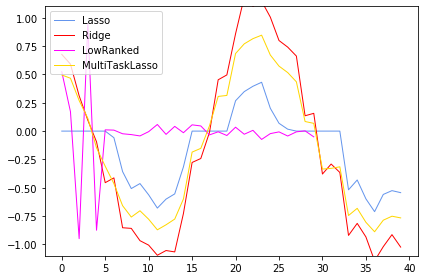

In [11]:
feature_to_plot = 0
lw = 1
"""
plt.plot(Y[:, feature_to_plot], color='seagreen', linewidth=lw,
            label='Ground truth')
"""
plt.plot(coef_lasso_[:, feature_to_plot], color='cornflowerblue',
            linewidth=lw,
            label='Lasso')
plt.plot(coef_ridge_[:, feature_to_plot], color='red',
            linewidth=lw,
            label='Ridge')
plt.plot(coef_low_ranked_[:, feature_to_plot], color='magenta',
            linewidth=lw,
            label='LowRanked')
plt.plot(coef_multi_task_lasso_[:, feature_to_plot], color='gold',
            linewidth=lw,
            label='MultiTaskLasso')
plt.legend(loc='upper left')
plt.axis('tight')
plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()

## **Conclusions apprentissage multi-tâches et régularisations**

* La régression MultiTaskLasso permet de fixer les variables explicatives (features) sélectionnées dans une tâche pour toutes les autres tâches. Ce qu'on observe bien ici dans le graphique des coefficients non négatifs du modèle.

* Cette régression permet de rendre la régression Lasso plus stable, ce qu'on observe sur le graphique de l'amplitude des coefficients du modèle.

* De plus, cette régression offre de meilleurs résultats que le modèle Lasso simple.

# Adaptation de domaine

Des implémentations de méthodes d'adaptation de domaine sont disponibles sur le web (par exemple : https://github.com/wmkouw/libTLDA).

* Télécharger un code qui implémente la méthode "kernel mean matching" et illustrer la méthode sur un jeu de données simulées ou réelles.

* On génère deux jeux de données avec des distributions différentes :





In [0]:
def generative_func(x):
    # same function used in paper
    return x ** 3 - x

def generate_data(n_samples, sigma, variance, gen_func):
    X = np.random.normal(sigma, variance ** 2, (n_samples, 1))

    Y = gen_func(X)

    # add some noise to our data
    Y += np.random.normal(0, 0.01, (n_samples, 1))

    # Y = Y.reshape((n_samples, 1))
    Y = np.array(Y)
    Y = Y.ravel()

    return X, Y

* Comparaison des différentes méthodes présentées dans le papier https://papers.nips.cc/paper/3075-correcting-sample-selection-bias-by-unlabeled-data.pdf

     pcost       dcost       gap    pres   dres
 0:  3.3512e+03  6.1114e+03  3e+05  3e+00  9e-01
 1:  9.8262e+03  4.3661e+03  8e+03  3e-02  8e-03
 2:  9.9714e+03  8.7289e+03  1e+03  2e-03  4e-04
 3:  9.7295e+03  8.6458e+03  1e+03  1e-03  3e-04
 4:  9.5111e+03  9.3304e+03  2e+02  6e-05  1e-05
 5:  9.4517e+03  9.4263e+03  3e+01  1e-16  8e-13
 6:  9.4454e+03  9.4396e+03  6e+00  1e-16  4e-12
 7:  9.4442e+03  9.4416e+03  3e+00  1e-16  2e-11
 8:  9.4433e+03  9.4429e+03  4e-01  2e-16  4e-12
 9:  9.4432e+03  9.4431e+03  9e-02  1e-16  3e-11
10:  9.4431e+03  9.4431e+03  2e-02  1e-16  5e-11
11:  9.4431e+03  9.4431e+03  1e-03  1e-16  2e-10
Optimal solution found.
[-0.9908139]
[1.12186014]
[-0.18099259]


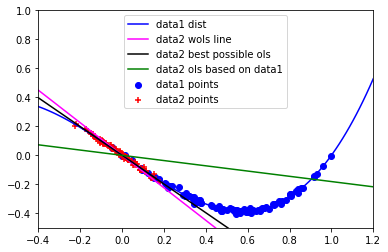

In [30]:
# generate 2 datasets with different gaussian distributions
n_samples = 100
sigma1, variance1 = 0.5, 0.5
sigma2, variance2 = 0, 0.3

data1, labels1 = generate_data(n_samples, sigma1, variance1, generative_func)
data2, labels2 = generate_data(n_samples, sigma2, variance2, generative_func)

# define the study range (same as in paper)
x_range = np.linspace(-0.4, 1.2, n_samples)

# let's get the best theorical fit
clf_best_ols = LinearRegression()
clf_best_ols.fit(data2, labels2)
best_ols_line = x_range * clf_best_ols.coef_

# let's get the predictions based on the linear regression model learnt on data1
clf_ols = LinearRegression()
clf_ols.fit(data1, labels1)
ols_line = x_range * clf_ols.coef_

# let's apply kmm algorithm !
clf_kmm = ImportanceWeightedClassifier(loss='quadratic', iwe='kmm')
clf_kmm.fit(data1, labels1, data2)
kmm_line = x_range * clf_kmm.clf.coef_

# ploting power !
plt.axis([-0.4, 1.2, -0.5, 1])

# data1 points and distribution
plt.scatter(data1, labels1, label='data1 points', color='blue', marker='o')
plt.plot(x_range, generative_func(x_range), label='data1 dist', color='blue')
# data2 points
plt.scatter(data2, labels2, label='data2 points', color='red', marker='+')
# kmm line
plt.plot(x_range, kmm_line, label='data2 wols line', color='magenta')
# best theorical ols
plt.plot(x_range, best_ols_line, label='data2 best possible ols', color='black')
# ols from data1
plt.plot(x_range, ols_line, label='data2 ols based on data1', color='green')

plt.legend(loc='upper center')
plt.show()

## **Conclusions adaptation de domaine**

* La méthode de `kernel mean matching` permet d'adapter l'apprentissage d'un jeu de données labélisé pour qu'il essaye de calculer la densité de distribution d'un autre jeu de données non labélisé.

* Cette méthode donne de meilleurs résultats en pratique que la simple application de la régression apprise sur le jeu de données labélisé au jeu non labélisé.